In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
import geopandas as gpd
from shapely.wkt import loads
from pyproj import Proj, Transformer

In [ ]:

def lat_lon_to_axis(lat, lon, axis_direction=(1, 0), crs="EPSG:3857", length_of_df=len(main_df)):
    """
    Convert latitude and longitude to a one-dimensional value in meters along an axis.

    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        axis_direction (tuple): Direction vector of the axis (x, y).
        crs (str): CRS for projecting to meters (default: EPSG:3857).

    Returns:
        float: One-dimensional projection value in meters.
    """
    
    # Define the transformer for projecting lat/lon to the desired CRS
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    
    # Project the latitude and longitude to meters
    x, y = transformer.transform(lon, lat)
    
    # Normalize the axis direction vector
    axis_vector = np.array(axis_direction)
    axis_unit_vector = axis_vector / np.linalg.norm(axis_vector)
    
    # Compute the projection of the point onto the axis
    projection_value = np.dot([x, y], axis_unit_vector)
    return projection_value

def find_traffic_light_id(row, segments_gdf):
    """
    Find the nearest segment ID to a given row in a DataFrame.

    Args:
        row (pd.Series): Row in a DataFrame with columns 'lat' and 'lon'.
        segments_gdf (gpd.GeoDataFrame): GeoDataFrame with segment geometries.

    Returns:
        int: ID of the nearest segment.
    """
    # Create a GeoDataFrame for the point
    point = gpd.GeoDataFrame(
        geometry=[loads(f"POINT ({row['lat']} {row['lon']})")], crs="EPSG:4326" # Make sure lat and lon is given completely right! Lat first then lon
    )
    
    # Reproject both point and segments to a projected CRS for accurate distance calculations
    projected_crs = "EPSG:4326"  # Common projected CRS for distance calculations
    point_proj = point.to_crs(projected_crs)
    segments_gdf_proj = segments_gdf.to_crs(projected_crs)
    max_distance = float("inf")
    nearest_segment_id = None
    for index, row in segments_gdf_proj.iterrows():
        distance = row.geometry.distance(point_proj.geometry[0])
        if distance < max_distance:
            max_distance = distance
            nearest_segment_id = index
    print(f"Nearest segment ID: {nearest_segment_id} and distance: {max_distance}")
    return nearest_segment_id


In [139]:
# loading the main dataframe
main_df = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_traffic.csv")
# loading the traffic light states
with open("20181024_d1_0830_0900_traffic_light_states.json") as f:
    traffic_info = json.load(f)
# loading the segments
segments_gdf = gpd.read_file("20181024_d1_0830_0900_segments.csv")
# Convert to GeoDataFrame
if "geometry" in segments_gdf.columns:
    # Convert 'geometry' to shapely objects if needed
    segments_gdf["geometry"] = segments_gdf["geometry"].apply(loads)
    # Create GeoDataFrame and set the CRS to WGS 84 (latitude/longitude)
    segments_gdf = gpd.GeoDataFrame(segments_gdf, geometry="geometry", crs="EPSG:4326")
else:
    raise ValueError("The DataFrame does not have a 'geometry' column.")

# Reproject to a projected CRS (replace EPSG code with appropriate UTM zone)
segments_gdf = segments_gdf.to_crs("EPSG:25832")  # Example for UTM Zone 32N

# Calculate lengths
segments_gdf["length"] = segments_gdf.geometry.length
segments_gdf = segments_gdf.to_crs("EPSG:4326")  # Example for UTM Zone 32N

pos_1_one_axis_trajectory = []
pos_2_one_axis_trajectory = []
for i, row in segments_gdf.iterrows():
    pos_1_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[0][1], row.geometry.coords.xy[0][0], crs="EPSG:4326"))
    pos_2_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[1][1], row.geometry.coords.xy[1][0], crs="EPSG:4326"))

segments_gdf["pos_1_one_axis_trajectory"] = pos_1_one_axis_trajectory
segments_gdf["pos_2_one_axis_trajectory"] = pos_2_one_axis_trajectory

# Calculate total length
total_length = segments_gdf["length"].sum()

# loading the traffic lights
traffic_lights_df = pd.read_csv("traffic_lights.csv")
# find traffic light segment id
traffic_lights_df["nearest_segment_id"] = traffic_lights_df.apply(find_traffic_light_id, axis=1, segments_gdf=segments_gdf)
# loading the traffic light states
with open("traffic_info_dict.pkl", "rb") as f:
    traffic_lights_dict_states = pickle.load(f)

Nearest segment ID: 0 and distance: 2.8376200689623273e-05
Nearest segment ID: 2 and distance: 5.7246700122574465e-05
Nearest segment ID: 4 and distance: 4.4298872346839304e-05
Nearest segment ID: 8 and distance: 1.4276374208940898e-05
Nearest segment ID: 10 and distance: 8.240561170737787e-05
Nearest segment ID: 14 and distance: 5.485557673347994e-05


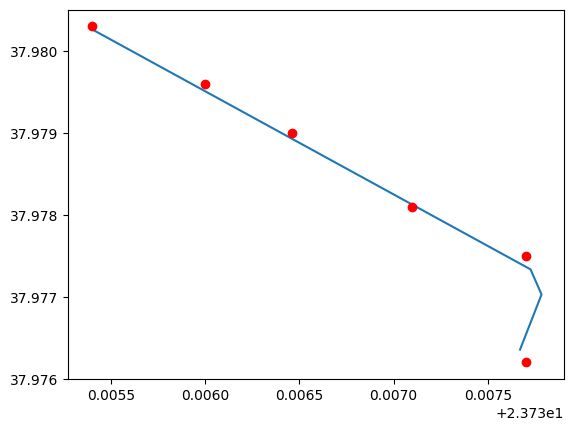

In [137]:
plt.plot(segments_gdf["pos_2_one_axis_trajectory"], segments_gdf["pos_1_one_axis_trajectory"], "-")
plt.plot(traffic_lights_df["lon"], traffic_lights_df["lat"], "ro")


In [131]:
segments_gdf_crs

,geometry,length,pos_1_one_axis_trajectory,pos_2_one_axis_trajectory
0,"LINESTRING (37.98027 23.73539, 37.98001 23.7356)",40.142563,3.540931e+06,2.953774e+06
1,"LINESTRING (37.98001 23.7356, 37.97974 23.73582)",40.142427,3.540896e+06,2.953793e+06
2,"LINESTRING (37.97974 23.73582, 37.97947 23.73603)",40.142291,3.540861e+06,2.953812e+06
3,"LINESTRING (37.97947 23.73603, 37.9792 23.73624)",40.142155,3.540825e+06,2.953831e+06
4,"LINESTRING (37.9792 23.73624, 37.97894 23.73645)",40.142018,3.540790e+06,2.953850e+06
5,"LINESTRING (37.97894 23.73645, 37.97867 23.73667)",40.141882,3.540754e+06,2.953869e+06
6,"LINESTRING (37.97867 23.73667, 37.9784 23.73688)",40.141746,3.540719e+06,2.953888e+06
7,"LINESTRING (37.9784 23.73688, 37.97814 23.73709)",40.141610,3.540684e+06,2.953907e+06
8,"LINESTRING (37.97814 23.73709, 37.97787 23.7373)",40.141473,3.540648e+06,2.953926e+06
9,"LINESTRING (37.97787 23.7373, 37.9776 23.73751)",40.141337,3.540613e+06,2.953945e+06


# Define the constants

In [44]:
DISTANCE_THRESHOLD = 5

# Normalize the one axis trajectory

In [48]:
from CTM_class import CTMParameters, initialize_density, update_cell_status
from helper import veh_to_density
from sklearn.preprocessing import normalize

# Initialize CTM parameters
ctm_params = CTMParameters()
ctm_params.cell_length = segments_gdf["length"].mean()

# Initialize densities for each segment
segment_densities = {idx: initialize_density() for idx in segments_gdf.index}

# Truncate points that are too far from the main corridor line
main_df_truncated = main_df[main_df["temp_distance"] < DISTANCE_THRESHOLD].copy()  # Ensure it's a copy

# Normalize trajectory
normalized_trajectory = (
    main_df_truncated["one_axis_trajectory"] - main_df_truncated["one_axis_trajectory"].min()
)
normalized_trajectory = normalized_trajectory / normalized_trajectory.max() * segments_gdf["length"].sum()

# Assign to the DataFrame safely
main_df_truncated.loc[:, "normalized_trajectory"] = normalized_trajectory


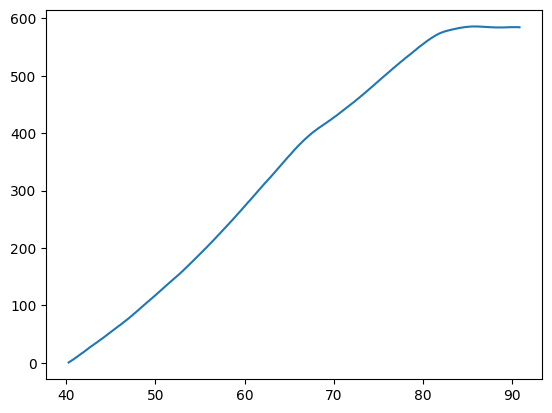

In [51]:
main_df_truncated

,lat,lon,speed,lon_acc,lat_acc,time,dist_to_start,dist_to_end,veh_id,segment_id,temp_distance,one_axis_trajectory,closest_traffic_light,distance_to_traffic_light,normalized_trajectory
0,37.979949,23.735613,29.3152,-0.1790,-0.0253,0.00,9.254831,459.678657,32.0,1.0,3.190766,2.642236e+06,0,43.220861,63.437439
1,37.979946,23.735615,29.2910,-0.1578,-0.0291,0.04,9.586996,459.303356,32.0,1.0,3.224027,2.642237e+06,0,43.597100,63.916212
2,37.979944,23.735617,29.2684,-0.1552,-0.0329,0.08,9.857971,459.030760,32.0,1.0,3.188256,2.642237e+06,0,43.873348,64.394986
3,37.979941,23.735619,29.2469,-0.1446,-0.0366,0.12,10.194706,458.655467,32.0,1.0,3.221517,2.642237e+06,0,44.249611,64.873759
4,37.979939,23.735621,29.2288,-0.1061,-0.0403,0.16,10.467632,458.382890,32.0,1.0,3.185746,2.642237e+06,0,44.525965,65.352532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672406,37.980044,23.735572,28.9885,0.3464,0.7262,818.64,6.830528,470.813214,918.0,0.0,0.196335,2.642232e+06,0,32.183260,53.622590
672407,37.980041,23.735574,29.0103,0.3757,0.7476,818.68,6.678863,470.437966,918.0,0.0,0.229596,2.642232e+06,0,32.559763,54.101363
672408,37.980039,23.735576,29.0349,0.3894,0.7668,818.72,6.627068,470.165489,918.0,0.0,0.193825,2.642232e+06,0,32.838304,54.580136
672409,37.980036,23.735577,29.0621,0.4186,0.7833,818.76,6.446423,469.823714,918.0,0.0,0.314004,2.642232e+06,0,33.173530,54.819523


In [82]:
segments_gdf

,geometry,length,pos_1_one_axis_trajectory,pos_2_one_axis_trajectory
0,"LINESTRING (3540931.311 2953774.261, 3540895.9...",40.142563,NaN,NaN
1,"LINESTRING (3540895.934 2953793.231, 3540860.5...",40.142427,NaN,NaN
2,"LINESTRING (3540860.556 2953812.201, 3540825.1...",40.142291,NaN,NaN
3,"LINESTRING (3540825.179 2953831.171, 3540789.8...",40.142155,NaN,NaN
4,"LINESTRING (3540789.802 2953850.141, 3540754.4...",40.142018,NaN,NaN
5,"LINESTRING (3540754.425 2953869.111, 3540719.0...",40.141882,NaN,NaN
6,"LINESTRING (3540719.049 2953888.081, 3540683.6...",40.141746,NaN,NaN
7,"LINESTRING (3540683.672 2953907.051, 3540648.2...",40.141610,NaN,NaN
8,"LINESTRING (3540648.296 2953926.021, 3540612.9...",40.141473,NaN,NaN
9,"LINESTRING (3540612.919 2953944.991, 3540577.5...",40.141337,NaN,NaN
